In [ ]:
# import tensorflow as tf

In [1]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

2023-11-30 02:22:46.934926: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 02:22:46.958871: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 02:22:46.958895: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 02:22:46.958933: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 02:22:46.964273: I tensorflow/core/platform/cpu_feature_g

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10344022061522209962
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1807745024
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10114186471676203
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


2023-11-30 02:22:48.117889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 02:22:48.122413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 02:22:48.122433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 02:22:49.485777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 02:22:49.485814: I tensorflow/compile

In [2]:
# os.chdir("/mnt/")
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/Annaantonin/Data.git

In [ ]:
rm -rf Data

In [ ]:
import Data as data
# data = sio.loadmat("Data/sdof_2000.mat")

In [ ]:
!git clone https://github.com/Crunch-UQ4MI/neuraluq.git
#!git clone https://github.com/Annaantonin/Data.git
!pip install tensorflow-probability
!pip install scipy
import os
os.chdir("/tf/neuraluq/")
!python setup.py install

In [ ]:
os.listdir(".")

In [119]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  4 16:14:30 2023

@author: Antonina
"""

#%%
# Simulated SDOF with:
#K_true=10;
# C_true=0.2236; %system damping ratio 5%

# m=5; %mass for sdof example

def load_data(noise):

    #data = sio.loadmat(r"G:\My Drive\Python_codes\NNs\sdof_ymeas.mat")
    data = sio.loadmat("Data/sin_force_noise.mat")
    #  t_x_train, t_f_train = data["t"], data["ymeas"]
    # data = matdata['data']
    x_tt_train, t_train = data["a"], data["t"]
    x_train, f_train = data["u"], data["force"]
    # Input_train=t, x_tt
    # train_x_tt = t_x_tt_train, x_train
    # train_f = t_f_train, f_train

    return  x_tt_train, t_train.T, x_train, f_train.T

#m=1
# [0][..., 0:1]     

def pde_fn(t, x, f, log_c, log_k):
    # log_k=tf.clip_by_value(log_k,np.log(0),np.log(20)) # to make constraints for the parameters
    # log_c=tf.clip_by_value(log_c,np.log(0),np.log(0.5))
    x_t = tf.gradients(x, t)     #velocity                                                                                                                                                                                                                   
    # x_tt = tf.gradients(x_t, t) [0]
    m=5 
    x_tt=(f-tf.exp(log_c) * x_t - tf.exp(log_k) * x)/m
    # f - tf.multiply(x_tt, 5.0)+ tf.exp(log_c) * x_t + tf.exp(log_k) * x
    # return [f,x_tt]
    return x_tt

def pde_xtt(t,x):
    x_t = tf.gradients(x, t)                                                                                                                                                                                                               
    x_tt = tf.gradients(x_t, t) 
    
    return x_tt
    
@neuq.utils.timer
def Trainable(
   x_tt_train, t_train, x_train, f_train, noise, layers, 
):
    # build processes
  
    process_x = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(layers=layers, regularizer=tf.keras.regularizers.l2(1e-5)),# displacement
    
    )
    process_f = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),  #, activation=tf.sigmoid
        posterior=neuq_vars.fnn.Trainable( layers=layers), #, regularizer=tf.keras.regularizers.l2(1e-5)
    )
    
    process_log_c = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_log_k = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    method = neuq.inferences.DEns(
        num_samples=10, num_iterations=5000, optimizer=tf.train.AdamOptimizer(1e-3),
    )

    # posterior = neuq_vars.pfnn.Trainable(
    #     layers=layers, num=10, regularizer=tf.keras.regularizers.l2(1e-5),
    # )
    
    # method = neuq.inferences.DEns(
    #     num_iterations=10000,
    #     optimizer=tf.train.AdamOptimizer(1e-3),
    #     is_parallelized=True,
    # )
    # build losses
    loss_x = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=x_tt_train, # could be the problem
        processes=[process_x],
        pde=pde_xtt, # dotdot _X
        multiplier=1,
    )
    
    loss_f = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=x_tt_train, # minimizing the loss to be close to zero
         # targets=np.zeros_like(t_train), # minimizing the loss to be close to zero
        processes=[process_x, process_f, process_log_c, process_log_k], # tf train
        pde=pde_fn,
        multiplier=1,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_x, process_f, process_log_c, process_log_k],
        likelihoods=[loss_x, loss_f],
    )
    # assign and compile method
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    # samples,results = model.run()
    # print("Acceptance rate: %.3f \n" % (np.mean(results)))
    
    processes = [process_x, process_f, process_log_c, process_log_k]
    return processes, samples, model


if __name__ == "__main__":

    noise = 0

    x_tt_train, t_train, x_train, f_train = load_data(noise)

    # t_x_tt_train, x_tt_train = train_x_tt
    # t_f_train, f_train = train_f

    layers = [1, 20, 20, 1]
    # layers_force = [1, 20, 20, 1]
    processes, samples, model = Trainable(
        x_tt_train, t_train, x_train, f_train, noise, layers, 
    )


    x_pred, f_pred, logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=None)
    (xtt_pred,) = model.predict(t_train, samples, processes, pde_fn=pde_fn)


2023-11-30 15:42:32.136315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 15:42:32.136368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 15:42:32.136379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 15:42:32.136823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 15:42:32.136849: I tensorflow/core/co

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...


2023-11-30 15:42:33.182091: W tensorflow/c/c_api.cc:305] Operation '{name:'Variable_371/Assign' id:23771 op device:{requested: '', assigned: ''} def:{{{node Variable_371/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Variable_371, Const_635)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.851093
Iteration:  1000 , loss:  0.71559626
Iteration:  2000 , loss:  0.40539074
Iteration:  3000 , loss:  0.304067
Iteration:  4000 , loss:  0.26809993
Generating 1th sample by deep ensemble...


2023-11-30 15:42:43.519936: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:24440 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.8594246
Iteration:  1000 , loss:  0.7027281
Iteration:  2000 , loss:  0.4683975
Iteration:  3000 , loss:  0.29642266
Iteration:  4000 , loss:  0.2581592
Generating 2th sample by deep ensemble...


2023-11-30 15:42:53.880918: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:24440 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.977643
Iteration:  1000 , loss:  0.73309356
Iteration:  2000 , loss:  0.42333457
Iteration:  3000 , loss:  0.30926028
Iteration:  4000 , loss:  0.2795618
Generating 3th sample by deep ensemble...


2023-11-30 15:43:04.151590: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:24440 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.8621507
Iteration:  1000 , loss:  0.73448086
Iteration:  2000 , loss:  0.3708116
Iteration:  3000 , loss:  0.29646274
Iteration:  4000 , loss:  0.27696314
Generating 4th sample by deep ensemble...


2023-11-30 15:43:13.887292: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:24440 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.9238725
Iteration:  1000 , loss:  0.7499715
Iteration:  2000 , loss:  0.53825516
Iteration:  3000 , loss:  0.37385294
Iteration:  4000 , loss:  0.2656355
Generating 5th sample by deep ensemble...


2023-11-30 15:43:22.388366: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:24440 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.808193
Iteration:  1000 , loss:  0.7106398
Iteration:  2000 , loss:  0.53015804
Iteration:  3000 , loss:  0.29901567
Iteration:  4000 , loss:  0.26732153
Generating 6th sample by deep ensemble...


2023-11-30 15:43:31.122231: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:24440 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.9487
Iteration:  1000 , loss:  0.66653574
Iteration:  2000 , loss:  0.47841057
Iteration:  3000 , loss:  0.30470407
Iteration:  4000 , loss:  0.2605611
Generating 7th sample by deep ensemble...


2023-11-30 15:43:39.514475: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:24440 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.8465157
Iteration:  1000 , loss:  0.7014175
Iteration:  2000 , loss:  0.4977831
Iteration:  3000 , loss:  0.29359707
Iteration:  4000 , loss:  0.26027158
Generating 8th sample by deep ensemble...


2023-11-30 15:43:47.886255: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:24440 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.878673
Iteration:  1000 , loss:  0.71227145
Iteration:  2000 , loss:  0.41923985
Iteration:  3000 , loss:  0.29016274
Iteration:  4000 , loss:  0.25746688
Generating 9th sample by deep ensemble...


2023-11-30 15:43:56.374706: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:24440 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  8.003892
Iteration:  1000 , loss:  0.7217636
Iteration:  2000 , loss:  0.4025181
Iteration:  3000 , loss:  0.3091205
Iteration:  4000 , loss:  0.2752232
Execution time for 'Trainable' function is: 92.629 s, 1.544 mins


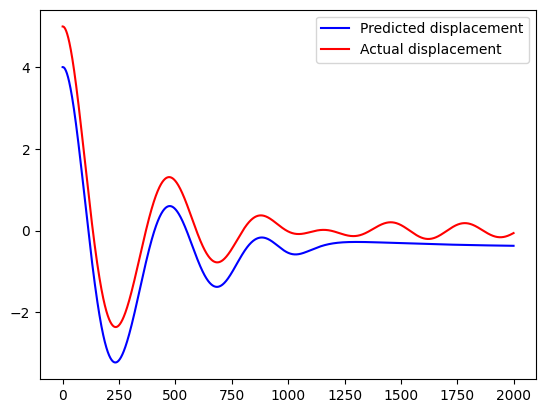

In [122]:
# [a.shape for a in samples]
# plt.plot(t_train,np.mean(x_pred,axis=(0, 2)),label='Predicted displacement')
# plt.plot(t_train,x_train,'r',label='Actual displacement')
# plt.legend()
# plt.plot(t_train,np.mean(x_pred,axis=(0, 2)),label='Predicted displacement')
# plt.plot(t_train,x_train,'r',label='Actual displacement')
# plt.legend()
x_pred.shape
plt.plot(x_pred[9,:,0],'b',label='Predicted displacement')
plt.plot(x_train,'r',label='Actual displacement')
plt.legend()

In [103]:
x_pred.shape

(10, 2000, 1)

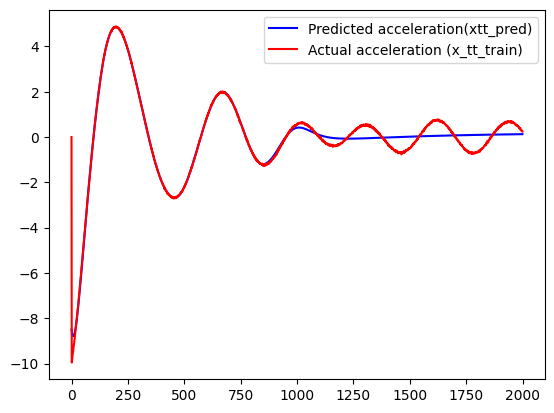

In [123]:
xtt_pred.shape
plt.plot(xtt_pred[0,9,:,9],'b',label='Predicted acceleration(xtt_pred)')
plt.plot(x_tt_train,'r',label='Actual acceleration (x_tt_train)')
plt.legend()

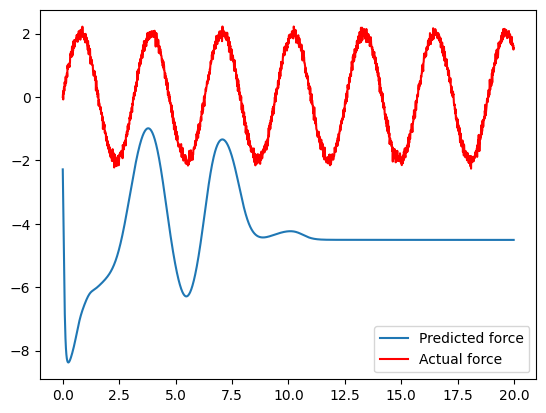

In [127]:
# (f_pred,) = model.predict(t_train, samples, processes, pde_fn=pde_fn)
plt.plot(t_train,np.mean(f_pred,axis=(0, 2)),label='Predicted force')
plt.plot(t_train,f_train,'r',label='Actual force')
plt.legend()

In [ ]:
# x_pred, logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=None)
# x_pred, logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=pde_fn)
# f_pred.shape
# plt.plot(xtt_pred[0].flatten())
# plt.plot(x_tt_train)

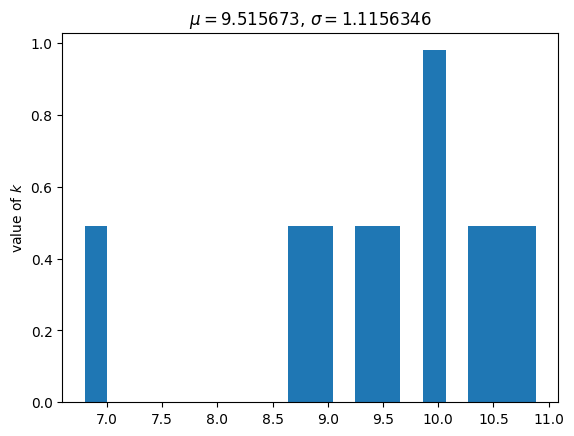

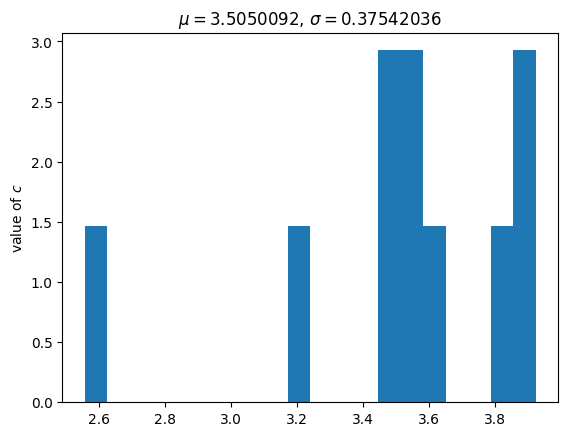

In [125]:
neuq.utils.hist(np.exp(logk_pred).flatten(), name="value of $k$")
neuq.utils.hist(np.exp(logc_pred).flatten(), name="value of $c$")

In [126]:
K_post=np.mean(np.exp(logk_pred))
print("K_true=10(N/m) and K_post =", K_post) 
C_post=np.mean(np.exp(logc_pred))
print("C_true=0.22(Ns/m) and C_post =", C_post) 

K_true=10(N/m) and K_post = 9.515673
C_true=0.22(Ns/m) and C_post = 3.5050092
